# CORA - Categorizing academic publications using getML

In this notebook, we compare getML against extant approaches in the relational learning literature on the CORA data set, which is often used for benchmarking. We demonstrate that getML outperforms the state of the art in the relational learning literature on this data set.

Summary:

- Prediction type: __Classification model__
- Domain: __Academia__
- Prediction target: __The category of a paper__ 
- Population size: __2708__

_Author: Dr. Patrick Urbanke_

# Background

CORA is a well-known benchmarking dataset in the academic literature on relational learning. The dataset contains 2708 scientific publications on machine learning. The papers are divided into 7 categories. The challenge is to predict the category of a paper based on the papers it cites, the papers it is cited by and keywords contained in the paper.

It has been downloaded from the [CTU Prague relational learning repository](https://relational.fit.cvut.cz/dataset/CORA) (Motl and Schulte, 2015).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

getml.engine.set_project('cora')


Connected to project 'cora'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data from the source file:

In [2]:
conn = getml.database.connect_mariadb(
    host="relational.fit.cvut.cz",
    dbname="CORA",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(conn_id='default', dbname='CORA', dialect='mysql', 
           host='relational.fit.cvut.cz', port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
paper = load_if_needed("paper")
cites = load_if_needed("cites")
content = load_if_needed("content")

In [5]:
paper

Name,paper_id,class_label
Role,unused_float,unused_string
0,35,Genetic_Algorithms
1,40,Genetic_Algorithms
2,114,Reinforcement_Learning
3,117,Reinforcement_Learning
4,128,Reinforcement_Learning
,...,...
2703,1154500,Case_Based
2704,1154520,Neural_Networks
2705,1154524,Rule_Learning


In [6]:
cites

Name,cited_paper_id,citing_paper_id
Role,unused_float,unused_float
0,35,887
1,35,1033
2,35,1688
3,35,1956
4,35,8865
,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289


In [7]:
content

Name,paper_id,word_cited_id
Role,unused_float,unused_string
0,35,word100
1,35,word1152
2,35,word1175
3,35,word1228
4,35,word1248
,...,...
49211,1155073,word75
49212,1155073,word759
49213,1155073,word789


### 1.2 Prepare data for getML

getML requires that we define *roles* for each of the columns.

In [8]:
paper.set_role("paper_id", getml.data.roles.join_key)
paper.set_role("class_label", getml.data.roles.categorical)
paper

Name,paper_id,class_label
Role,join_key,categorical
0,35,Genetic_Algorithms
1,40,Genetic_Algorithms
2,114,Reinforcement_Learning
3,117,Reinforcement_Learning
4,128,Reinforcement_Learning
,...,...
2703,1154500,Case_Based
2704,1154520,Neural_Networks
2705,1154524,Rule_Learning


In [9]:
cites.set_role(["cited_paper_id", "citing_paper_id"], getml.data.roles.join_key)
cites

Name,cited_paper_id,citing_paper_id
Role,join_key,join_key
0,35,887
1,35,1033
2,35,1688
3,35,1956
4,35,8865
,...,...
5424,853116,19621
5425,853116,853155
5426,853118,1140289


We need to separate our data set into a training, testing and validation set:

In [10]:
content.set_role("paper_id", getml.data.roles.join_key)
content.set_role("word_cited_id", getml.data.roles.categorical)
content

Name,paper_id,word_cited_id
Role,join_key,categorical
0,35,word100
1,35,word1152
2,35,word1175
3,35,word1228
4,35,word1248
,...,...
49211,1155073,word75
49212,1155073,word759
49213,1155073,word789


We also have to separate the data set into a training and testing set:

In [11]:
random = paper.random()

is_training = (random < 0.7)
is_test = (~is_training)

data_train = paper.where("data_train", is_training)
data_test = paper.where("data_test", is_test)

The goal is to predict seven different labels. We generate a target column for each of those labels:

In [12]:
class_label = np.unique(paper.class_label.to_numpy())
class_label

array(['Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
       'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning',
       'Theory'], dtype='<U22')

In [13]:
def make_target_columns(data_frame):
    for label in class_label:
        name = "class_label=" + label
        data_frame[name] = (data_frame.class_label == label)
        data_frame.set_role(name, getml.data.roles.target)
    data_frame.set_role("class_label", getml.data.roles.unused_string)

In [14]:
make_target_columns(data_train)
make_target_columns(data_test)

In [15]:
data_train

Name,paper_id,class_label=Case_Based,class_label=Genetic_Algorithms,class_label=Neural_Networks,class_label=Probabilistic_Methods,class_label=Reinforcement_Learning,class_label=Rule_Learning,class_label=Theory,class_label
Role,join_key,target,target,target,target,target,target,target,unused_string
0,35,0,1,0,0,0,0,0,Genetic_Algorithms
1,114,0,0,0,0,1,0,0,Reinforcement_Learning
2,130,0,0,0,0,1,0,0,Reinforcement_Learning
3,288,0,0,0,0,1,0,0,Reinforcement_Learning
4,424,0,0,0,0,0,1,0,Rule_Learning
,...,...,...,...,...,...,...,...,...
1882,1154276,0,0,1,0,0,0,0,Neural_Networks
1883,1154459,0,1,0,0,0,0,0,Genetic_Algorithms
1884,1154500,1,0,0,0,0,0,0,Case_Based


In [16]:
data_test

Name,paper_id,class_label=Case_Based,class_label=Genetic_Algorithms,class_label=Neural_Networks,class_label=Probabilistic_Methods,class_label=Reinforcement_Learning,class_label=Rule_Learning,class_label=Theory,class_label
Role,join_key,target,target,target,target,target,target,target,unused_string
0,40,0,1,0,0,0,0,0,Genetic_Algorithms
1,117,0,0,0,0,1,0,0,Reinforcement_Learning
2,128,0,0,0,0,1,0,0,Reinforcement_Learning
3,164,0,0,0,0,0,0,1,Theory
4,463,1,0,0,0,0,0,0,Case_Based
,...,...,...,...,...,...,...,...,...
816,1154173,0,0,0,1,0,0,0,Probabilistic_Methods
817,1154229,0,0,0,1,0,0,0,Probabilistic_Methods
818,1154233,0,0,0,1,0,0,0,Probabilistic_Methods


## 2. Predictive modelling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

### 2.1 Define relational model

To get started with relational learning, we need to specify the data model. Even though the data set itself is quite simple with only three tables and six columns in total, the resulting data model is actually quite complicated.

That is because the class label can be predicting using three different pieces of information:

- The keywords used by the paper
- The keywords used by papers it cites and by papers that cite the paper
- The class label of papers it cites and by papers that cite the paper

In [17]:
population_ph = getml.data.Placeholder('population')
cites_ph = getml.data.Placeholder('cites')
cites2_ph = getml.data.Placeholder('cites')
content_ph = getml.data.Placeholder('content')
paper_ph = getml.data.Placeholder('paper')

population_ph.join(
    cites_ph,
    join_key='paper_id',
    other_join_key='cited_paper_id'
)

cites_ph.join(
    content_ph,
    join_key='citing_paper_id',
    other_join_key='paper_id',
)

cites_ph.join(
    paper_ph,
    join_key='citing_paper_id',
    other_join_key='paper_id',
    relationship=getml.data.relationship.many_to_one
)

population_ph.join(
    cites2_ph,
    join_key='paper_id',
    other_join_key='citing_paper_id'
)

cites2_ph.join(
    content_ph,
    join_key='cited_paper_id',
    other_join_key='paper_id'
)

cites2_ph.join(
    paper_ph,
    join_key='cited_paper_id',
    other_join_key='paper_id',
    relationship=getml.data.relationship.many_to_one
)

population_ph.join(
    content_ph,
    join_key='paper_id'
)

population_ph

placeholder   other placeholder   allow lagged targets   horizon    join keys used   memory   
population    cites               False                  0.0       paper_id          0.0      
population    cites               False                  0.0       paper_id          0.0      
population    content             False                  0.0       paper_id          0.0      
cites         content             False                  0.0       citing_paper_id   0.0      
cites         paper               False                  0.0       citing_paper_id   0.0      
cites         content             False                  0.0       cited_paper_id    0.0      
cites         paper               False                  0.0       cited_paper_id    0.0      



other join keys used   other time stamps used   relationship   time stamps used   
cited_paper_id                                  many-to-many                      
citing_paper_id                                 many-to-many                      
paper_id                                        many-to-many                      
paper_id                                        many-to-many                      
paper_id                                        many-to-one                       
paper_id                                        many-to-many                      
paper_id                                        many-to-one                       



other join keys used   upper time stamps used   
cited_paper_id                                  
citing_paper_id                                 
paper_id                                        
paper_id                                        
paper_id                                        
paper_id                                        
paper_id

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We use the relboost algorithms for this problem. Because of the large number of keywords, we regularize the model a bit by requiring a minimum support for the keywords (`min_num_samples`).

In [18]:
relboost = getml.feature_learning.RelboostModel(
    num_features=10,
    num_subfeatures=10,
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    seed=4367,
    num_threads=1,
    min_num_samples=30
)

predictor = getml.predictors.XGBoostClassifier()

__Build the pipeline__

In [19]:
peripheral_ph = [cites_ph, content_ph, paper_ph]

pipe = getml.pipeline.Pipeline(
    tags=['relboost'],
    population=population_ph,
    peripheral=peripheral_ph,
    feature_learners=[relboost],
    predictors=[predictor]
)

### 2.3 Model training

In [20]:
peripheral = {
    "cites": cites, 
    "content": content, 
    "paper": paper
}

In [21]:
pipe.check(data_train, peripheral)

INFO [MIGHT TAKE LONG]: The number of unique entries in column 'word_cited_id' in  data frame 'content' is 1432. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
INFO [JOIN KEYS NOT FOUND]: When joining  data frame 'population' and the composite data frame 'cites'-'paper' that has been created by many-to-one joins or one-to-one joins over 'paper_id' and 'cited_paper_id', there are no corresponding entries for 41.759406% of entries in 'paper_id' in ' data frame 'population''. You might want to double-check your join keys.
INFO [JOIN KEYS NOT FOUND]: When joining  data frame 'population' and the composite data frame 'cites'-'paper' that has been created by many-to-one joins or one-to-one joins over 'paper_id' and 'citing_paper_id', there are no corresponding entries for 17.700053% of entries in 'paper_id' in ' data frame 'population''. You mi

Checking data model...


The training process seems a bit intimidating. That is because the relboost algorithms needs to train separate models for each class label. This is due to the nature of the generated features.

In [22]:
pipe.fit(data_train, peripheral)

INFO [MIGHT TAKE LONG]: The number of unique entries in column 'word_cited_id' in  data frame 'content' is 1432. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
INFO [JOIN KEYS NOT FOUND]: When joining  data frame 'population' and the composite data frame 'cites'-'paper' that has been created by many-to-one joins or one-to-one joins over 'paper_id' and 'cited_paper_id', there are no corresponding entries for 41.759406% of entries in 'paper_id' in ' data frame 'population''. You might want to double-check your join keys.
INFO [JOIN KEYS NOT FOUND]: When joining  data frame 'population' and the composite data frame 'cites'-'paper' that has been created by many-to-one joins or one-to-one joins over 'paper_id' and 'citing_paper_id', there are no corresponding entries for 17.700053% of entries in 'paper_id' in ' data frame 'population''. You mi

Checking data model...

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Training features...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[========================================] 100%

Relboost: Training subfeatures...
[===============================

Pipeline(preprocessors=[], feature_learners=['RelboostModel'], 
         feature_selectors=[], include_categorical=False, 
         peripheral=['cites', 'content', 'paper'], population='population', 
         predictors=['XGBoostClassifier'], tags=['relboost'], 
         share_selected_features=0.5)

url: http://localhost:1709/#/getpipeline/cora/ZH5EqG/0/

### 2.4 Model evaluation

In [23]:
pipe.score(data_test, peripheral)


Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost:

,date time,set used,target,accuracy,auc,cross entropy
0,2021-01-08 14:39:27,data_train,class_label=Case_Based,1,1.00000,0.00774
1,2021-01-08 14:39:27,data_train,class_label=Genetic_Algorithms,1,1.00000,0.00349
2,2021-01-08 14:39:27,data_train,class_label=Neural_Networks,0.985691573926868,0.99874,0.05138
3,2021-01-08 14:39:27,data_train,class_label=Probabilistic_Methods,0.9989401165871754,0.99998,0.01179
4,2021-01-08 14:39:27,data_train,class_label=Reinforcement_Learning,1,1.00000,0.00405
5,2021-01-08 14:39:27,data_train,class_label=Rule_Learning,1,1.00000,0.00268
6,2021-01-08 14:39:27,data_train,class_label=Theory,0.9984101748807631,0.99986,0.02021
7,2021-01-08 14:39:30,data_test,class_label=Case_Based,0.97442143727162,0.98890,0.08473
8,2021-01-08 14:39:30,data_test,class_label=Genetic_Algorithms,0.9914738124238733,0.99863,0.05082
9,2021-01-08 14:39:30,data_test,class_label=Neural_Networks,0.9476248477466505,0.97475,0.18136


To make things a bit easier, we just look at our test results.

In [24]:
pipe.scores.filter(lambda score: score.set_used == "data_test")

,date time,set used,target,accuracy,auc,cross entropy
0,2021-01-08 14:39:30,data_test,class_label=Case_Based,0.97442,0.98890,0.08473
1,2021-01-08 14:39:30,data_test,class_label=Genetic_Algorithms,0.99147,0.99863,0.05082
2,2021-01-08 14:39:30,data_test,class_label=Neural_Networks,0.94762,0.97475,0.18136
3,2021-01-08 14:39:30,data_test,class_label=Probabilistic_Methods,0.96711,0.97701,0.13363
4,2021-01-08 14:39:30,data_test,class_label=Reinforcement_Learning,0.98051,0.98009,0.09029
5,2021-01-08 14:39:30,data_test,class_label=Rule_Learning,0.98051,0.99176,0.06742
6,2021-01-08 14:39:30,data_test,class_label=Theory,0.94153,0.96915,0.17197


We take the average of the AUC values, which is also the value that appears in the getML monitor (http://localhost:1709/#/listpipelines/cora).

In [25]:
np.mean(pipe.auc)

0.9828981416647291

The accuracy for multiple targets can be calculated using one of two methods. The first method is to simply take the average of the pair-wise accuracy values, which is also the value that appears in the getML monitor (http://localhost:1709/#/listpipelines/cora).

In [26]:
np.mean(pipe.accuracy)

0.9690273186010092

However, the benchmarking papers actually use a different approach: 

- They first generate probabilities for each of the labels:

In [27]:
probabilities = pipe.predict(data_test, peripheral)


Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building features...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost: Building subfeatures...
[========================================] 100%

Relboost:

- They then find the class label with the highest probability:

In [28]:
ix_max = np.argmax(probabilities, axis=1)
predicted_labels = np.asarray([class_label[ix] for ix in ix_max])

- They then compare that value to the actual class label:

In [29]:
actual_labels = data_test.class_label.to_numpy()

print("Share of accurately predicted class labels:")
(actual_labels == predicted_labels).sum() / len(predicted_labels)

Share of accurately predicted class labels:


0.8928136419001218

Since this is the method the benchmark papers use, this is the accuracy score we will report as well.

### 2.6 Studying features

__Feature correlations__

We want to analyze how the features are correlated with the target variables.

In [30]:
TARGET_NUM = 0

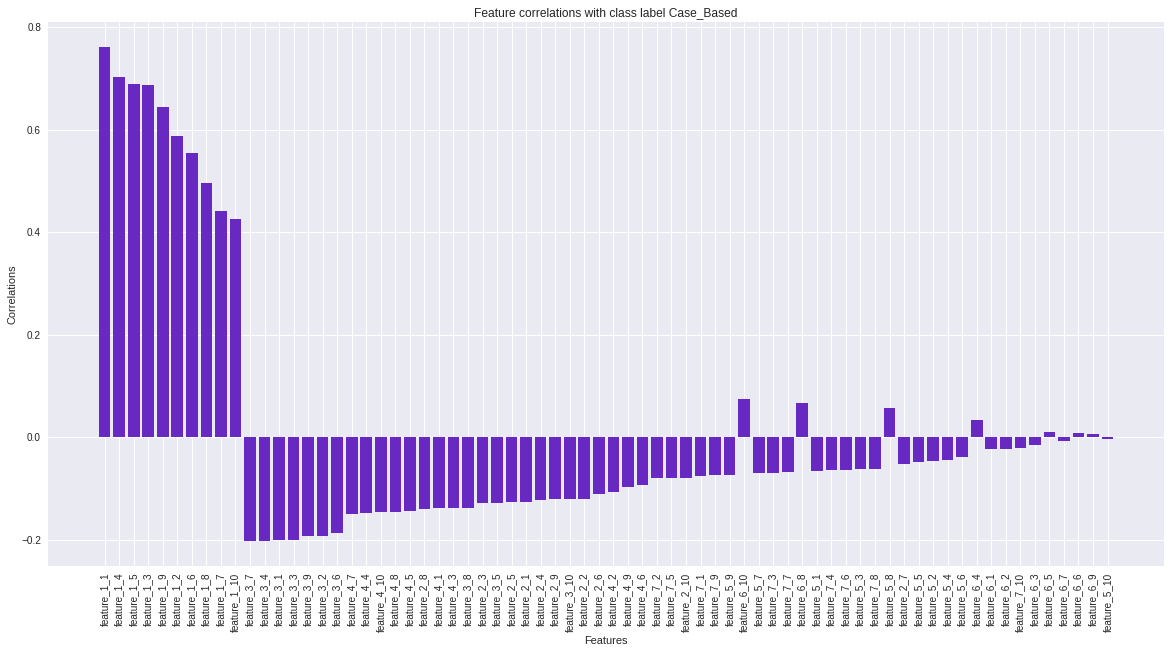

In [31]:
names, correlations = pipe.features.correlations(target_num=TARGET_NUM)

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations, color='#6829c2')

plt.title('Feature correlations with class label ' + class_label[TARGET_NUM])
plt.xlabel('Features')
plt.ylabel('Correlations')
plt.xticks(rotation='vertical')
plt.show()

__Feature importances__
 
Feature importances are calculated by analyzing the improvement in predictive accuracy on each node of the trees in the XGBoost predictor. They are then normalized, so that all importances add up to 100%.

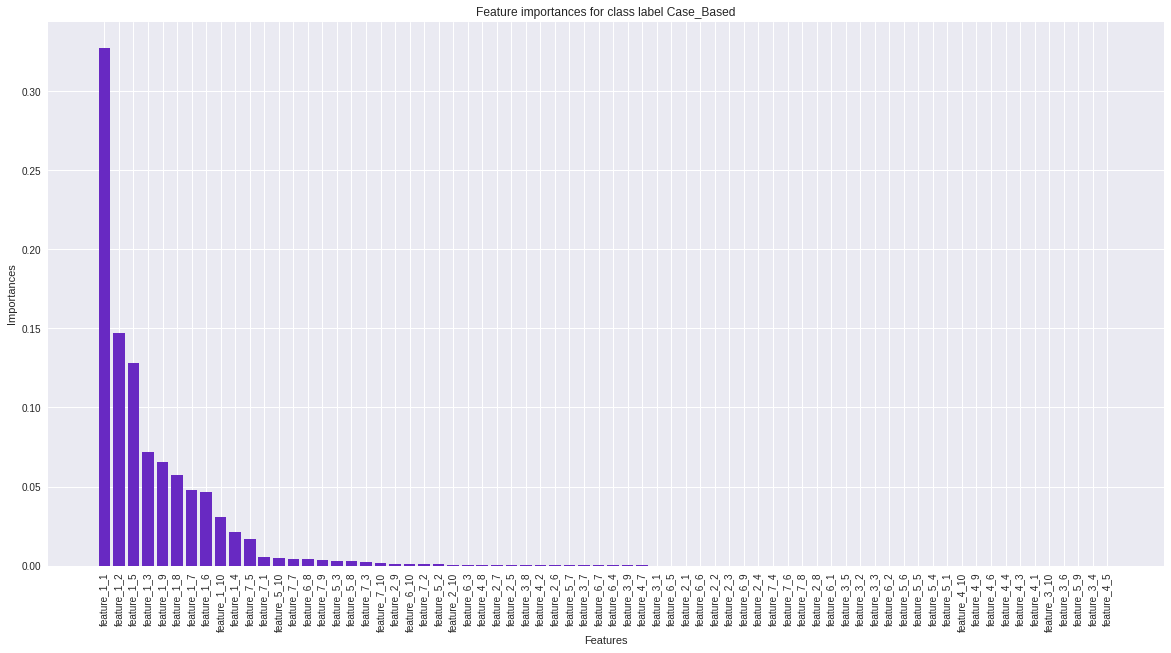

In [32]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Feature importances for class label ' + class_label[TARGET_NUM])
plt.xlabel('Features')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Column importances__

Because getML uses relational learning, we can apply the principles we used to calculate the feature importances to individual columns as well.

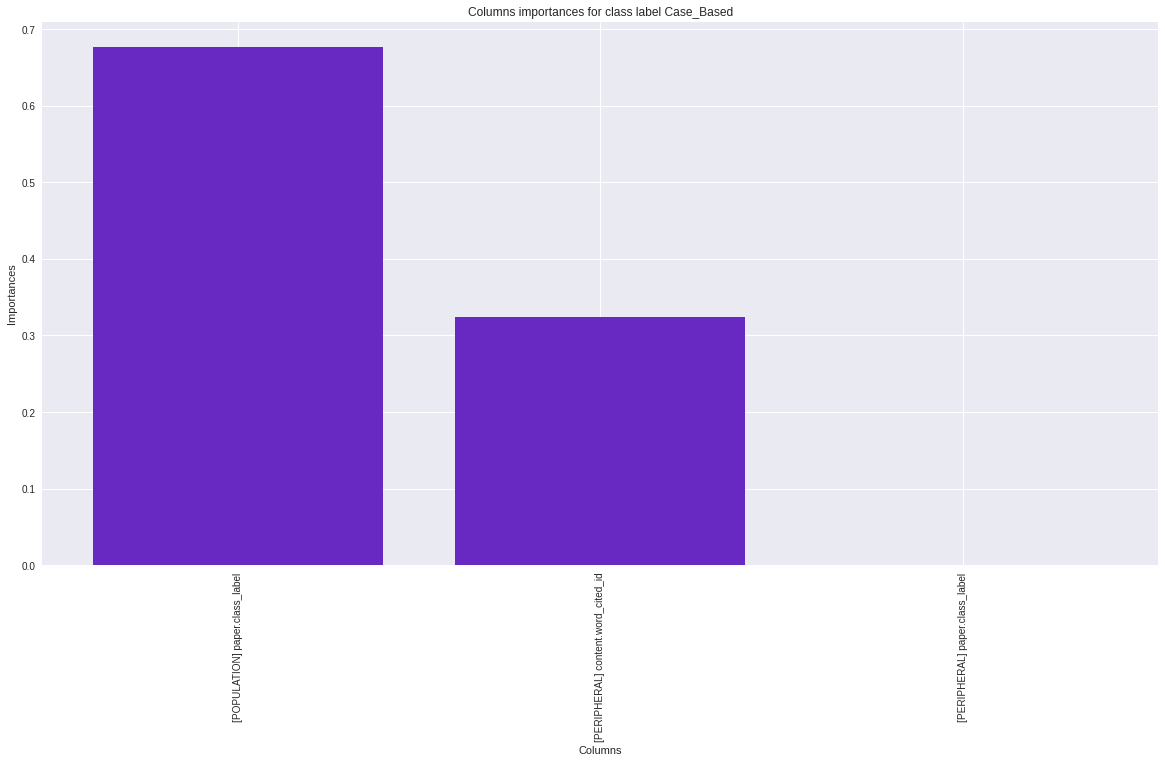

In [33]:
names, importances = pipe.columns.importances(target_num=TARGET_NUM)

plt.subplots(figsize=(20, 10))

plt.bar(names, importances, color='#6829c2')

plt.title('Columns importances for class label ' + class_label[TARGET_NUM])
plt.xlabel('Columns')
plt.ylabel('Importances')
plt.xticks(rotation='vertical')
plt.show()

__Transpiling the learned features__

We can also transpile the learned features to SQLite3 code. We want to show the two most important features. That is why we call the `.features.importances().` method again. The names that are returned are already sorted by importance.

In [34]:
names, _ = pipe.features.importances(target_num=TARGET_NUM)

pipe.features.to_sql()[names[0]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_1";

CREATE TABLE "FEATURE_1_1" AS
SELECT AVG( 
    CASE
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) > 3.005381 ) AND ( COALESCE( f_1_2_8."feature_1_2_8", 0.0 ) > -0.033636 ) AND ( COALESCE( f_1_2_6."feature_1_2_6", 0.0 ) > 2.053150 ) THEN 9.551721315361849
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) > 3.005381 ) AND ( COALESCE( f_1_2_8."feature_1_2_8", 0.0 ) > -0.033636 ) AND ( COALESCE( f_1_2_6."feature_1_2_6", 0.0 ) <= 2.053150 ) THEN 8.345447169579023
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) > 3.005381 ) AND ( COALESCE( f_1_2_8."feature_1_2_8", 0.0 ) <= -0.033636 ) THEN 3.562975903781937
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) <= 3.005381 ) AND ( COALESCE( f_1_2_4."feature_1_2_4", 0.0 ) > 0.990553 ) AND ( COALESCE( f_1_2_17."feature_1_2_17", 0.0 ) > 0.133425 ) THEN 3.170190448516549
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) <= 3.005381 ) AND ( COALESCE( f_1_2_4."feature_1_2_4", 0.0 ) > 0.990553 ) AND ( COALESCE( f_1_2_17."feature_1_2_17", 0.0 ) <= 0.133425 ) THEN -0.2941441629310396
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) <= 3.005381 ) AND ( COALESCE( f_1_2_4."feature_1_2_4", 0.0 ) <= 0.990553 ) AND ( COALESCE( f_1_2_16."feature_1_2_16", 0.0 ) > 0.061872 ) THEN 0.008612839513795153
        WHEN ( COALESCE( f_1_2_1."feature_1_2_1", 0.0 ) <= 3.005381 ) AND ( COALESCE( f_1_2_4."feature_1_2_4", 0.0 ) <= 0.990553 ) AND ( COALESCE( f_1_2_16."feature_1_2_16", 0.0 ) <= 0.061872 ) THEN -1.331020133336617
        ELSE NULL
    END
) AS "feature_1_1",
     t1.rowid AS "rownum"
FROM "population" t1
LEFT JOIN "cites" t2
ON t1."paper_id" = t2."citing_paper_id"
LEFT JOIN "paper" t4
ON t2."cited_paper_id" = t4."paper_id"
LEFT JOIN "FEATURE_1_2_1" f_1_2_1
ON t2.rowid = f_1_2_1."rownum"
LEFT JOIN "FEATURE_1_2_4" f_1_2_4
ON t2.rowid = f_1_2_4."rownum"
LEFT JOIN "FEATURE_1_2_6" f_1_2_6
ON t2.rowid = f_1_2_6."rownum"
LEFT JOIN "FEATURE_1_2_8" f_1_2_8
ON t2.rowid = f_1_2_8."rownum"
LEFT JOIN "FEATURE_1_2_16" f_1_2_16
ON t2.rowid = f_1_2_16."rownum"
LEFT JOIN "FEATURE_1_2_17" f_1_2_17
ON t2.rowid = f_1_2_17."rownum"
GROUP BY t1.rowid;
```

In [35]:
pipe.features.to_sql()["feature_1_2_1"]

```sql
DROP TABLE IF EXISTS "FEATURE_1_2_1";

CREATE TABLE "FEATURE_1_2_1" AS
SELECT AVG( 
    CASE
        WHEN ( t4."class_label" IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" IN ( 'word508', 'word1076', 'word1150', 'word1264', 'word1204', 'word1302' ) ) AND ( t2."word_cited_id" IN ( 'word508' ) ) THEN -41.04048315947784
        WHEN ( t4."class_label" IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" IN ( 'word508', 'word1076', 'word1150', 'word1264', 'word1204', 'word1302' ) ) AND ( t2."word_cited_id" NOT IN ( 'word508' ) ) THEN -6.377878658886826
        WHEN ( t4."class_label" IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" NOT IN ( 'word508', 'word1076', 'word1150', 'word1264', 'word1204', 'word1302' ) ) AND ( t2."word_cited_id" IN ( 'word1132', 'word1178', 'word1210', 'word1231', 'word1263', 'word759', 'word1398', 'word5', 'word764', 'word751' ) ) THEN 17.47638906704596
        WHEN ( t4."class_label" IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" NOT IN ( 'word508', 'word1076', 'word1150', 'word1264', 'word1204', 'word1302' ) ) AND ( t2."word_cited_id" NOT IN ( 'word1132', 'word1178', 'word1210', 'word1231', 'word1263', 'word759', 'word1398', 'word5', 'word764', 'word751' ) ) THEN 7.854942060649063
        WHEN ( t4."class_label" NOT IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" IN ( 'word100', 'word1152', 'word1228', 'word1248', 'word1250', 'word1306', 'word141', 'word192', 'word20', 'word386', 'word496', 'word639', 'word749', 'word775', 'word866', 'word1006', 'word1076', 'word1139', 'word1178', 'word1275', 'word1293', 'word293', 'word730', 'word1133', 'word264', 'word1072', 'word1210', 'word1329', 'word212', 'word213', 'word238', 'word649', 'word778', 'word916', 'word188', 'word42', 'word582', 'word127', 'word1309', 'word1382', 'word204', 'word285', 'word1212', 'word1260', 'word759', 'word922', 'word1350', 'word1353', 'word136', 'word724', 'word781', 'word620', 'word1055', 'word1061', 'word1318', 'word667', 'word60', 'word725', 'word813', 'word1424', 'word3', 'word52', 'word703', 'word784', 'word1080', 'word40', 'word475', 'word66', 'word1067', 'word1340', 'word1357', 'word158', 'word457', 'word534', 'word1111', 'word1423', 'word423', 'word472', 'word565', 'word587', 'word68', 'word82', 'word1209', 'word1332', 'word396', 'word750', 'word1390', 'word169', 'word177', 'word930', 'word1291', 'word1180', 'word549', 'word895', 'word300', 'word379', 'word912', 'word974', 'word861', 'word1012', 'word1393', 'word820', 'word1356', 'word592', 'word1273', 'word1296', 'word1358', 'word1362', 'word1385', 'word446', 'word544', 'word559', 'word86', 'word448', 'word1167', 'word1036', 'word1098', 'word1110', 'word137', 'word447', 'word598', 'word695', 'word78', 'word698', 'word765', 'word214', 'word1331', 'word946', 'word59', 'word1230', 'word1387', 'word53', 'word780', 'word81', 'word970', 'word699', 'word811', 'word1235', 'word368', 'word1028', 'word180', 'word331', 'word817', 'word855', 'word129', 'word515', 'word62', 'word925', 'word1213', 'word1274', 'word913', 'word968', 'word1118', 'word1121', 'word878', 'word1188', 'word239', 'word932', 'word1173', 'word510', 'word1352', 'word1377', 'word662', 'word132', 'word152', 'word147', 'word1115', 'word134', 'word1419', 'word923', 'word27', 'word306', 'word694', 'word752', 'word809', 'word4', 'word251', 'word522', 'word958', 'word979', 'word987', 'word1082', 'word1425', 'word894', 'word248', 'word1092', 'word1053', 'word1074', 'word1392', 'word1237', 'word58', 'word787', 'word1256', 'word255', 'word654', 'word940', 'word352', 'word972', 'word1176', 'word1346', 'word57', 'word1236', 'word1203', 'word822', 'word7', 'word1413', 'word1415' ) ) AND ( t2."word_cited_id" IN ( 'word1006', 'word1139', 'word1178', 'word1293', 'word730', 'word1133', 'word264', 'word213', 'word916', 'word188', 'word42', 'word127', 'word204', 'word1260', 'word922', 'word1353', 'word136', 'word724', 'word781', 'word60', 'word725', 'word3', 'word703', 'word784', 'word475', 'word66', 'word1067', 'word534', 'word1111', 'word1423', 'word587', 'word68', 'word82', 'word1209', 'word1332', 'word750', 'word1291', 'word1180', 'word379', 'word861', 'word1012', 'word1393', 'word820', 'word1167', 'word1036', 'word1098', 'word698', 'word765', 'word214', 'word1331', 'word946', 'word59', 'word1387', 'word53', 'word780', 'word1235', 'word368', 'word180', 'word331', 'word817', 'word129', 'word515', 'word925', 'word913', 'word968', 'word932', 'word1173', 'word132', 'word152', 'word1115', 'word134', 'word1419', 'word923', 'word27', 'word306', 'word809', 'word251', 'word958', 'word1082', 'word248', 'word1074', 'word940', 'word352', 'word57', 'word7' ) ) THEN -5.937783518951274
        WHEN ( t4."class_label" NOT IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" IN ( 'word100', 'word1152', 'word1228', 'word1248', 'word1250', 'word1306', 'word141', 'word192', 'word20', 'word386', 'word496', 'word639', 'word749', 'word775', 'word866', 'word1006', 'word1076', 'word1139', 'word1178', 'word1275', 'word1293', 'word293', 'word730', 'word1133', 'word264', 'word1072', 'word1210', 'word1329', 'word212', 'word213', 'word238', 'word649', 'word778', 'word916', 'word188', 'word42', 'word582', 'word127', 'word1309', 'word1382', 'word204', 'word285', 'word1212', 'word1260', 'word759', 'word922', 'word1350', 'word1353', 'word136', 'word724', 'word781', 'word620', 'word1055', 'word1061', 'word1318', 'word667', 'word60', 'word725', 'word813', 'word1424', 'word3', 'word52', 'word703', 'word784', 'word1080', 'word40', 'word475', 'word66', 'word1067', 'word1340', 'word1357', 'word158', 'word457', 'word534', 'word1111', 'word1423', 'word423', 'word472', 'word565', 'word587', 'word68', 'word82', 'word1209', 'word1332', 'word396', 'word750', 'word1390', 'word169', 'word177', 'word930', 'word1291', 'word1180', 'word549', 'word895', 'word300', 'word379', 'word912', 'word974', 'word861', 'word1012', 'word1393', 'word820', 'word1356', 'word592', 'word1273', 'word1296', 'word1358', 'word1362', 'word1385', 'word446', 'word544', 'word559', 'word86', 'word448', 'word1167', 'word1036', 'word1098', 'word1110', 'word137', 'word447', 'word598', 'word695', 'word78', 'word698', 'word765', 'word214', 'word1331', 'word946', 'word59', 'word1230', 'word1387', 'word53', 'word780', 'word81', 'word970', 'word699', 'word811', 'word1235', 'word368', 'word1028', 'word180', 'word331', 'word817', 'word855', 'word129', 'word515', 'word62', 'word925', 'word1213', 'word1274', 'word913', 'word968', 'word1118', 'word1121', 'word878', 'word1188', 'word239', 'word932', 'word1173', 'word510', 'word1352', 'word1377', 'word662', 'word132', 'word152', 'word147', 'word1115', 'word134', 'word1419', 'word923', 'word27', 'word306', 'word694', 'word752', 'word809', 'word4', 'word251', 'word522', 'word958', 'word979', 'word987', 'word1082', 'word1425', 'word894', 'word248', 'word1092', 'word1053', 'word1074', 'word1392', 'word1237', 'word58', 'word787', 'word1256', 'word255', 'word654', 'word940', 'word352', 'word972', 'word1176', 'word1346', 'word57', 'word1236', 'word1203', 'word822', 'word7', 'word1413', 'word1415' ) ) AND ( t2."word_cited_id" NOT IN ( 'word1006', 'word1139', 'word1178', 'word1293', 'word730', 'word1133', 'word264', 'word213', 'word916', 'word188', 'word42', 'word127', 'word204', 'word1260', 'word922', 'word1353', 'word136', 'word724', 'word781', 'word60', 'word725', 'word3', 'word703', 'word784', 'word475', 'word66', 'word1067', 'word534', 'word1111', 'word1423', 'word587', 'word68', 'word82', 'word1209', 'word1332', 'word750', 'word1291', 'word1180', 'word379', 'word861', 'word1012', 'word1393', 'word820', 'word1167', 'word1036', 'word1098', 'word698', 'word765', 'word214', 'word1331', 'word946', 'word59', 'word1387', 'word53', 'word780', 'word1235', 'word368', 'word180', 'word331', 'word817', 'word129', 'word515', 'word925', 'word913', 'word968', 'word932', 'word1173', 'word132', 'word152', 'word1115', 'word134', 'word1419', 'word923', 'word27', 'word306', 'word809', 'word251', 'word958', 'word1082', 'word248', 'word1074', 'word940', 'word352', 'word57', 'word7' ) ) THEN -2.090331577653417
        WHEN ( t4."class_label" NOT IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" NOT IN ( 'word100', 'word1152', 'word1228', 'word1248', 'word1250', 'word1306', 'word141', 'word192', 'word20', 'word386', 'word496', 'word639', 'word749', 'word775', 'word866', 'word1006', 'word1076', 'word1139', 'word1178', 'word1275', 'word1293', 'word293', 'word730', 'word1133', 'word264', 'word1072', 'word1210', 'word1329', 'word212', 'word213', 'word238', 'word649', 'word778', 'word916', 'word188', 'word42', 'word582', 'word127', 'word1309', 'word1382', 'word204', 'word285', 'word1212', 'word1260', 'word759', 'word922', 'word1350', 'word1353', 'word136', 'word724', 'word781', 'word620', 'word1055', 'word1061', 'word1318', 'word667', 'word60', 'word725', 'word813', 'word1424', 'word3', 'word52', 'word703', 'word784', 'word1080', 'word40', 'word475', 'word66', 'word1067', 'word1340', 'word1357', 'word158', 'word457', 'word534', 'word1111', 'word1423', 'word423', 'word472', 'word565', 'word587', 'word68', 'word82', 'word1209', 'word1332', 'word396', 'word750', 'word1390', 'word169', 'word177', 'word930', 'word1291', 'word1180', 'word549', 'word895', 'word300', 'word379', 'word912', 'word974', 'word861', 'word1012', 'word1393', 'word820', 'word1356', 'word592', 'word1273', 'word1296', 'word1358', 'word1362', 'word1385', 'word446', 'word544', 'word559', 'word86', 'word448', 'word1167', 'word1036', 'word1098', 'word1110', 'word137', 'word447', 'word598', 'word695', 'word78', 'word698', 'word765', 'word214', 'word1331', 'word946', 'word59', 'word1230', 'word1387', 'word53', 'word780', 'word81', 'word970', 'word699', 'word811', 'word1235', 'word368', 'word1028', 'word180', 'word331', 'word817', 'word855', 'word129', 'word515', 'word62', 'word925', 'word1213', 'word1274', 'word913', 'word968', 'word1118', 'word1121', 'word878', 'word1188', 'word239', 'word932', 'word1173', 'word510', 'word1352', 'word1377', 'word662', 'word132', 'word152', 'word147', 'word1115', 'word134', 'word1419', 'word923', 'word27', 'word306', 'word694', 'word752', 'word809', 'word4', 'word251', 'word522', 'word958', 'word979', 'word987', 'word1082', 'word1425', 'word894', 'word248', 'word1092', 'word1053', 'word1074', 'word1392', 'word1237', 'word58', 'word787', 'word1256', 'word255', 'word654', 'word940', 'word352', 'word972', 'word1176', 'word1346', 'word57', 'word1236', 'word1203', 'word822', 'word7', 'word1413', 'word1415' ) ) AND ( t2."word_cited_id" IN ( 'word83' ) ) THEN 55.80329289561103
        WHEN ( t4."class_label" NOT IN ( 'Case_Based' ) ) AND ( t2."word_cited_id" NOT IN ( 'word100', 'word1152', 'word1228', 'word1248', 'word1250', 'word1306', 'word141', 'word192', 'word20', 'word386', 'word496', 'word639', 'word749', 'word775', 'word866', 'word1006', 'word1076', 'word1139', 'word1178', 'word1275', 'word1293', 'word293', 'word730', 'word1133', 'word264', 'word1072', 'word1210', 'word1329', 'word212', 'word213', 'word238', 'word649', 'word778', 'word916', 'word188', 'word42', 'word582', 'word127', 'word1309', 'word1382', 'word204', 'word285', 'word1212', 'word1260', 'word759', 'word922', 'word1350', 'word1353', 'word136', 'word724', 'word781', 'word620', 'word1055', 'word1061', 'word1318', 'word667', 'word60', 'word725', 'word813', 'word1424', 'word3', 'word52', 'word703', 'word784', 'word1080', 'word40', 'word475', 'word66', 'word1067', 'word1340', 'word1357', 'word158', 'word457', 'word534', 'word1111', 'word1423', 'word423', 'word472', 'word565', 'word587', 'word68', 'word82', 'word1209', 'word1332', 'word396', 'word750', 'word1390', 'word169', 'word177', 'word930', 'word1291', 'word1180', 'word549', 'word895', 'word300', 'word379', 'word912', 'word974', 'word861', 'word1012', 'word1393', 'word820', 'word1356', 'word592', 'word1273', 'word1296', 'word1358', 'word1362', 'word1385', 'word446', 'word544', 'word559', 'word86', 'word448', 'word1167', 'word1036', 'word1098', 'word1110', 'word137', 'word447', 'word598', 'word695', 'word78', 'word698', 'word765', 'word214', 'word1331', 'word946', 'word59', 'word1230', 'word1387', 'word53', 'word780', 'word81', 'word970', 'word699', 'word811', 'word1235', 'word368', 'word1028', 'word180', 'word331', 'word817', 'word855', 'word129', 'word515', 'word62', 'word925', 'word1213', 'word1274', 'word913', 'word968', 'word1118', 'word1121', 'word878', 'word1188', 'word239', 'word932', 'word1173', 'word510', 'word1352', 'word1377', 'word662', 'word132', 'word152', 'word147', 'word1115', 'word134', 'word1419', 'word923', 'word27', 'word306', 'word694', 'word752', 'word809', 'word4', 'word251', 'word522', 'word958', 'word979', 'word987', 'word1082', 'word1425', 'word894', 'word248', 'word1092', 'word1053', 'word1074', 'word1392', 'word1237', 'word58', 'word787', 'word1256', 'word255', 'word654', 'word940', 'word352', 'word972', 'word1176', 'word1346', 'word57', 'word1236', 'word1203', 'word822', 'word7', 'word1413', 'word1415' ) ) AND ( t2."word_cited_id" NOT IN ( 'word83' ) ) THEN 0.6538483771533634
        ELSE NULL
    END
) AS "feature_1_2_1",
     t1.rowid AS "rownum"
FROM "cites" t1
LEFT JOIN "content" t2
ON t1."cited_paper_id" = t2."paper_id"
LEFT JOIN "paper" t4
ON t1."cited_paper_id" = t4."paper_id"
GROUP BY t1.rowid;
```

### 2.7 Benchmarks

State-of-the-art approaches on this data set perform as follows:

| Approach                      | Study                      | Accuracy     | AUC     |
| :--------------------------   | :------------------------  | -----------: | ------: |
| RelF                          | Dinh et al (2012)          | 85.7%        |     --  |
| LBP                           | Dinh et al (2012)          | 85.0%        |     --  |
| EPRN                          | Preisach and Thieme (2006) | 84.0%        |     --  |
| PRN                           | Preisach and Thieme (2006) | 81.0%        |     --  |
| ACORA                         | Perlich and Provost (2006) | --           |   97.0% |


As we can see, the performance of the relboost algorithm, as used in this notebook, compares favorably to these benchmarks.

| Approach                      | Accuracy     | AUC     |
| :---------------------------- | -----------: | ------: |
| relboost                      | 89.3%        | 98.3%   |


## 3. Conclusion

In this notebook we have demonstrated that getML outperforms state-of-the-art relational learning algorithms on the CORA dataset.

## Citations

Dinh, Quang-Thang, Christel Vrain, and Matthieu Exbrayat. "A Link-Based Method for Propositionalization." ILP (Late Breaking Papers). 2012.

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).

Perlich, Claudia, and Foster Provost. "Distribution-based aggregation for relational learning with identifier attributes." Machine Learning 62.1-2 (2006): 65-105.

Preisach, Christine, and Lars Schmidt-Thieme. "Relational ensemble classification." Sixth International Conference on Data Mining (ICDM'06). IEEE, 2006.

# Next Steps

This tutorial went through the basics of applying getML to relational data. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Occupancy detection: A multivariate time series example](occupancy_demo.ipynb)  
* [Expenditure categorization: Why relational learning matters](consumer_expenditures_demo.ipynb)
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)
* [Air pollution prediction: Why feature learning outperforms brute-force approaches](air_pollution_demo.ipynb) 


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


# Get in contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.